In [244]:
from cgr.filepaths import filepaths
from cgr.draw import draw_molecule, draw_reaction
import json
from IPython.display import SVG
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
from scipy.stats import entropy
import matplotlib.pyplot as plt

In [229]:
def show_rxn(sma: str):
    display(SVG(draw_reaction(sma)))

In [230]:
krs = filepaths.data / "raw" / "sprhea_240310_v3_mapped_no_subunits.json"
with open(krs, 'r') as f:
    krs = json.load(f)

In [231]:
decarb = {k: v for k,v  in krs.items() if v['min_rule'] == 'rule0024'}
print(len(decarb))

86


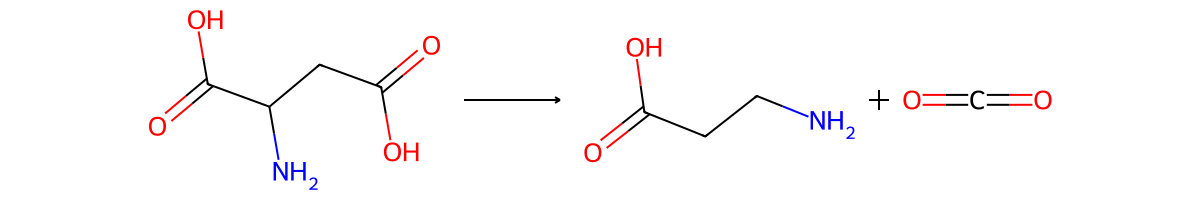

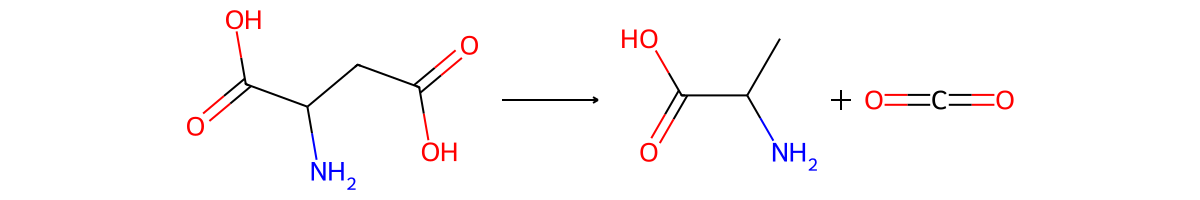

In [232]:
alpha_amino_id = '1162'
beta_amino_id = '17157'

alpha_smarts = decarb[alpha_amino_id]['smarts']
beta_smarts = decarb[beta_amino_id]['smarts']

alpha_smi = alpha_smarts.split('>>')[0]
beta_smi = beta_smarts.split('>>')[0]

alpha_mol = Chem.MolFromSmiles(alpha_smi)
beta_mol = Chem.MolFromSmiles(beta_smi)

show_rxn(alpha_smarts)
show_rxn(beta_smarts)

In [233]:
# TODO is atom idx canonical? Do I have to first canonicalize smiles? Will this matter?

def get_dai(atom: Chem.Atom):
    '''
    Returns Daylight atomic invariants for atom
    '''

    dai = [
        atom.GetDegree(), # Heavy atoms only
        atom.GetTotalValence() - atom.GetTotalNumHs(),
        atom.GetAtomicNum(),
        atom.GetMass(),
        atom.GetFormalCharge(),
        int(atom.IsInRing())
    ]

    return dai

def featurize_mol(mol: Chem.Mol, reaction_center: list[int] = []):
    '''
    Get atomic features for each atom in a molecule

    Args
    ----
    mol:Mol
        molecule
    reaction_center:list[int]
        List of atom indices of reaction center
        atoms. Should be ordered the same way for a given
        reaction center / operator. If provided, atomic feature
        set includes 
    '''
    feats = []
    for atom in mol.GetAtoms():
        aidx = atom.GetIdx()
        dai = get_dai(atom)

        spls = [
            len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0
            for rcidx in reaction_center
        ]

        feats.append(
            hash(
                tuple(
                    dai + spls
                )
            ) & 0xFFFFFFFF
        )

    return feats

def tanimoto_similarity(bitvec1: np.ndarray, bitvec2: np.ndarray):
    dot = np.dot(bitvec1, bitvec2)
    return dot / (bitvec1.sum() + bitvec2.sum() - dot)

In [234]:
radius = 3
length = 2**11
mfper = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=length)

In [235]:
alpha_mfp = mfper.GetFingerprintAsNumPy(alpha_mol)
beta_mfp = mfper.GetFingerprintAsNumPy(beta_mol)
tanimoto_similarity(alpha_mfp, beta_mfp)

np.float64(1.0)

In [236]:
alpha_rc = decarb[alpha_amino_id]['reaction_center'][0]
beta_rc = decarb[beta_amino_id]['reaction_center'][0]

alpha_feats = featurize_mol(alpha_mol, reaction_center=alpha_rc)
beta_feats = featurize_mol(beta_mol, reaction_center=beta_rc)

alpha_mfp_w_loc = mfper.GetFingerprintAsNumPy(alpha_mol, customAtomInvariants=alpha_feats)
beta_mfp_w_loc = mfper.GetFingerprintAsNumPy(beta_mol, customAtomInvariants=beta_feats)
tanimoto_similarity(alpha_mfp_w_loc, beta_mfp_w_loc)

np.float64(0.2777777777777778)

In [237]:
print(f"normal: {float((alpha_mfp.sum() / length) * 100):2f}% density")
print(f"w/ loc: {float((alpha_mfp_w_loc.sum() / length) * 100):2f}% density")

normal: 0.830078% density
w/ loc: 1.123047% density


In [238]:
kopts = list(decarb.keys())

@interact
def compare_two(key1 = widgets.Dropdown(value=kopts[0], options=kopts), key2 = widgets.Dropdown(value=kopts[0], options=kopts), radius: int = 3, length: int = 2**11):    
    mfper = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=length)
    svgs = []
    mfps = []
    mfps_w_loc = []
    for key in [key1, key2]:
        rxn = decarb[key]
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        svgs.append(widgets.HTML(draw_molecule(smiles, hilite_atoms=rc, size=(500, 300))))
        
        
        mol = Chem.MolFromSmiles(smiles)
        custom_feats = featurize_mol(mol, rc)
        mfps.append(mfper.GetFingerprintAsNumPy(mol))
        mfps_w_loc.append(mfper.GetFingerprintAsNumPy(mol, customAtomInvariants=custom_feats))
        
    ts = tanimoto_similarity(*mfps)
    ts_w_loc = tanimoto_similarity(*mfps_w_loc)

    print(f"standard: {ts}")
    print(f"w/ loc: {ts_w_loc}")

    display(widgets.HBox(svgs))

interactive(children=(Dropdown(description='key1', options=('14', '55', '121', '734', '1067', '1162', '1565', …

In [239]:
M = []
L = []
for key, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)
        custom_feats = featurize_mol(mol, rc)
        M.append(mfper.GetFingerprintAsNumPy(mol))
        L.append(mfper.GetFingerprintAsNumPy(mol, customAtomInvariants=custom_feats))

M = np.vstack(M)
L = np.vstack(L)

tmp = []
for elt in [M, L]:
    c = elt.sum(axis=1) # Cardinality
    S = np.matmul(M, M.T) # Straight dot product
    # tmp.append(S / (c.reshape(1, -1) + c.reshape(-1, 1) - S)) # Tanimoto similarity
    tmp.append(S)

Sm, Sl = tmp

In [256]:
kopts = list(decarb.keys())

@interact
def rank_by_one(query = widgets.Dropdown(value=kopts[0], options=kopts), w_loc: bool = True, topk: int = 10):    
    
    idx = kopts.index(query)
    if w_loc:
        sim_row = Sl[idx, :]
    else:
        sim_row = Sm[idx, :]


    srt_sim_key = sorted(zip(sim_row, kopts), key=lambda x : x[0], reverse=True)

    for i, (sim, k) in enumerate(srt_sim_key):
        if i == 0:
            print("Query")
        else:
            print(f"Other ID: {k}")
            print(f"Similarity score: {sim}")
        
        rxn = decarb[k]
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        display(SVG(draw_molecule(smiles, hilite_atoms=rc, size=(350, 200))))

        if i == 0:
            print('-' * 50)

        if i > topk:
            break

interactive(children=(Dropdown(description='query', options=('14', '55', '121', '734', '1067', '1162', '1565',…

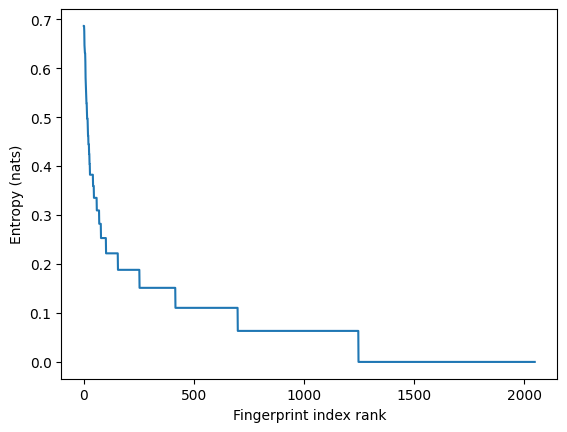

In [253]:
p1 = L.sum(axis=0) / L.shape[0]
probas = np.vstack((p1, (1 - p1)))
elt_entropy = entropy(pk=probas, axis=0)
fp_idx, elt_entropy = zip(*sorted(zip(np.arange(len(elt_entropy)), elt_entropy), key=lambda x : x[1], reverse=True))
x = np.arange(len(elt_entropy))

fig, ax = plt.subplots()
ax.plot(x, elt_entropy)
ax.set_ylabel("Entropy (nats)")
ax.set_xlabel("Fingerprint index rank")
plt.show()

In [305]:
fp_idx[:10], elt_entropy[:10]

((np.int64(1224),
  np.int64(1695),
  np.int64(1503),
  np.int64(1447),
  np.int64(1453),
  np.int64(269),
  np.int64(1711),
  np.int64(1130),
  np.int64(1903),
  np.int64(1669)),
 (np.float64(0.686371452146747),
  np.float64(0.686371452146747),
  np.float64(0.6757392797294369),
  np.float64(0.6467238528694028),
  np.float64(0.6391670481584251),
  np.float64(0.6310051928046935),
  np.float64(0.6310051928046935),
  np.float64(0.6128219041385707),
  np.float64(0.5806978226600542),
  np.float64(0.5686327461499967)))

In [261]:
radius = 3
length = 2**11
mfper = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=length)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()

L = []
bims = [] # BitInfoMaps {bit_idx: ((central atom idx, radius))}
mols = []
for key, rxn in decarb.items():
        rc = rxn['reaction_center'][0]
        smiles = rxn['smarts'].split('>>')[0]
        mol = Chem.MolFromSmiles(smiles)


        custom_feats = featurize_mol(mol, rc)
        L.append(mfper.GetFingerprintAsNumPy(mol, customAtomInvariants=custom_feats, additionalOutput=ao))
        bims.append(ao.GetBitInfoMap())
        mols.append(mol)

L = np.vstack(L)

15


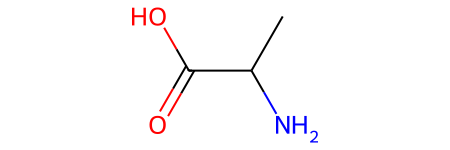

9


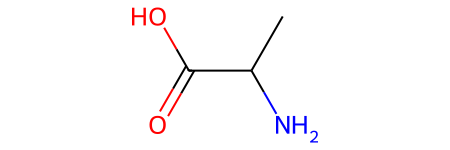

6


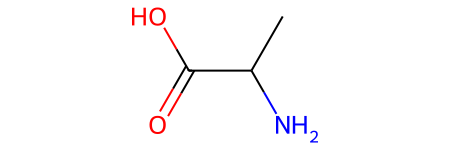

6


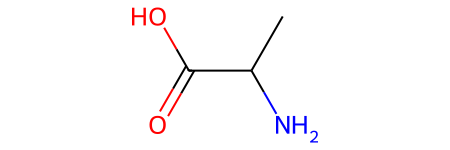

32


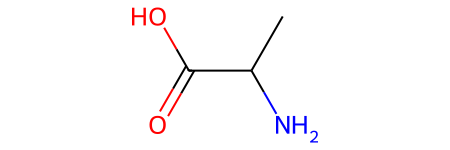

6


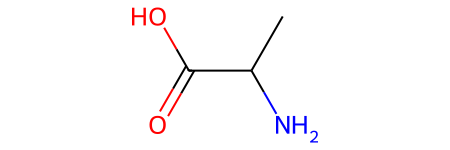

10


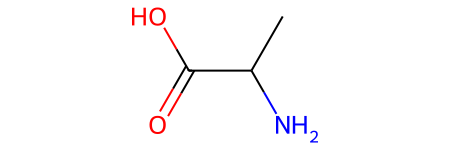

7


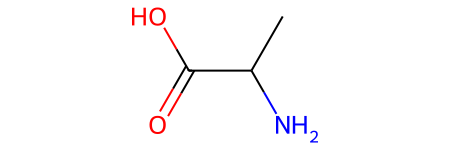

10


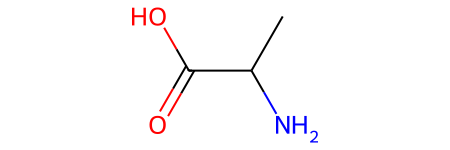

12


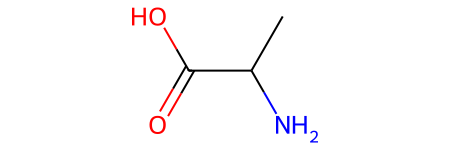

8


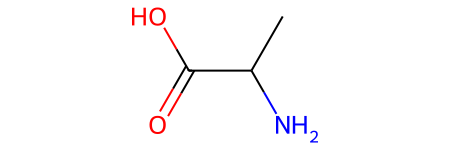

6


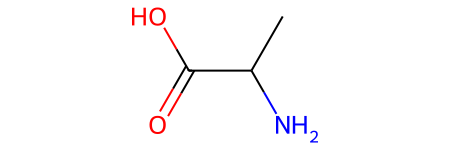

11


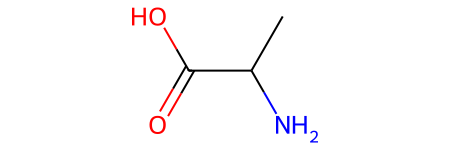

9


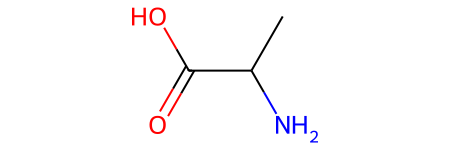

10


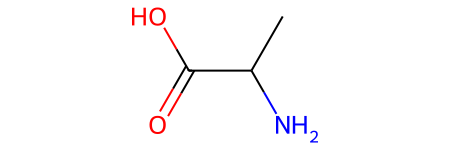

13


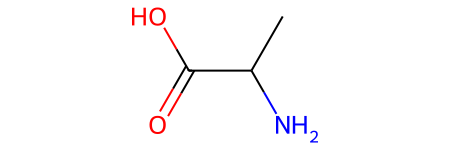

9


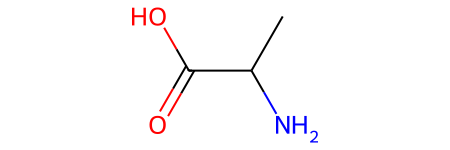

8


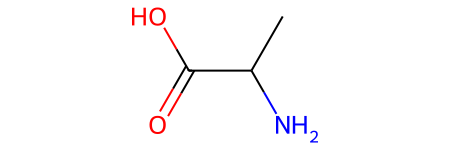

7


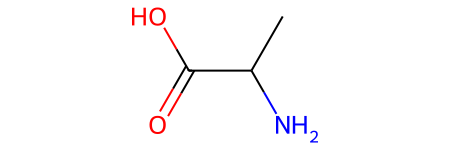

11


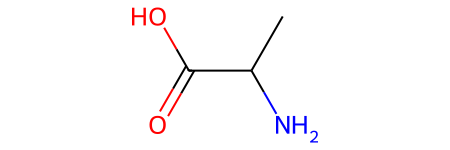

7


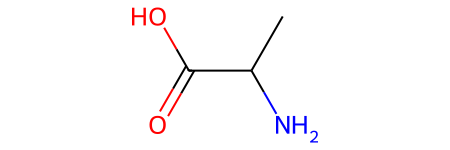

4


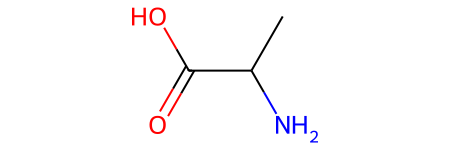

13


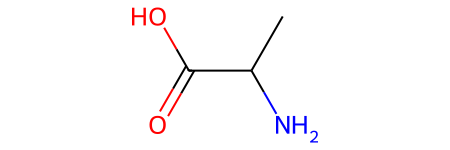

5


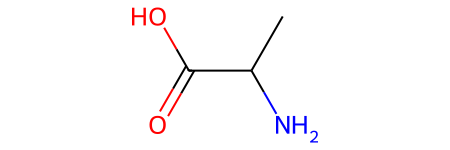

32


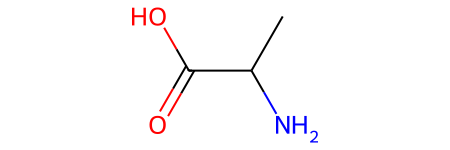

9


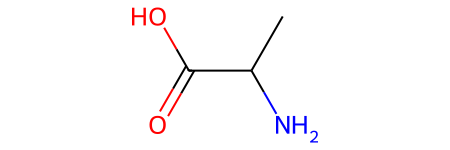

4


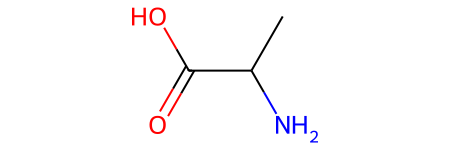

16


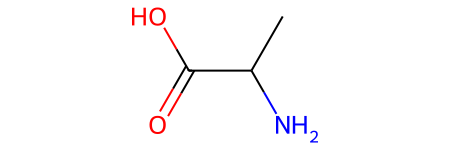

In [307]:
def get_submol(molecule: Chem.Mol, aidx: int, radius: int):
    env = Chem.FindAtomEnvironmentOfRadiusN(
        mol=molecule,
        radius=radius,
        rootedAtAtom=aidx
    )

    submol = Chem.PathToSubmol(
        mol=molecule,
        path=env    
    )

    return submol

idx = fp_idx[6]
for bim, mol in zip(bims, mols):
    if idx in bim:
        aidx, radius = bim[idx][0]
        # atom = mol.GetAtomWithIdx(aidx)
        # print(atom.GetAtomicNum())
        if radius > 0:
            submol = get_submol(mol, aidx, radius)
            print(aidx)
            display(submol)

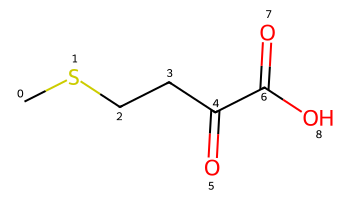

In [304]:
SVG(draw_molecule(Chem.MolToSmiles(mol), size=(350, 200), draw_options={'addAtomIndices': True}))

In [308]:
aidx, radius

(16, 2)

In [242]:
'''
TODO

- Show ecfp w/ loc sensitivity on alpha / beta amino
- Look at sparsity w/ and w/o loc info
- Develop bit to substructure traceback
- Develop visuzliation of structures
'''

'\nTODO\n\n- Show ecfp w/ loc sensitivity on alpha / beta amino\n- Look at sparsity w/ and w/o loc info\n- Develop bit to substructure traceback\n- Develop visuzliation of structures\n'